## Building the Bandit Class

We start with a basic bandit class.

As far as attributes, we already know that we need a probability of reward - that's the main attribute that controls the behavior.
this is a nice place to use a private attribute, to emphasize that it shouldn't be viewed from the outside.
And we want to be able to pull the lever on this machine - at least a representaton of pulling the lever, so we need a method.  we can call it pull.

In [86]:
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
    """A representation of a slot machine with a secret 
    probability of returning a reward."""
    def __init__(self):
        self.__probability = np.random.uniform()
        
    def __repr__(self):
        return "Bandit with secret probability " + str(self.__probability)
        
    def pull(self):
        """ Represents pulling the lever of this machine.  Returns True if reward
        is given, False otherwise."""
        return np.random.choice([True, False], 
                                p = [self.__probability, 1- self.__probability])

In [24]:
b = Bandit()
b

Bandit with secret probability 0.059596906970314056

In [28]:
trials = [ b.pull() for i in range(100)]
trials[:10]

[False, False, False, False, False, True, False, False, False, False]

In [29]:
sum(trials)

6

## A Basic Solver

In [262]:
class RandomSolver:
    
    def __init__(self, bandits):
        self.bandits = bandits
        
    def move(self):
        """Pulls one of this solver's bandits and returns True if a reward results,
        False, otherwise."""
        chosen = np.random.randint(0,len(self.bandits))
        # print("Solver chooses bandit", chosen)
        return self.bandits[chosen].pull()

In [45]:
bandits = [Bandit() for i in range(10)]

In [46]:
bandits

[Bandit with secret probability 0.5227912474492572,
 Bandit with secret probability 0.7356127498679114,
 Bandit with secret probability 0.1444839012421627,
 Bandit with secret probability 0.8497481014552938,
 Bandit with secret probability 0.5071387047248401,
 Bandit with secret probability 0.5708566750520796,
 Bandit with secret probability 0.1616172684777778,
 Bandit with secret probability 0.719139046828376,
 Bandit with secret probability 0.7332428001359813,
 Bandit with secret probability 0.8507592412350384]

In [47]:
s = RandomSolver(bandits)

In [53]:
s.move()

Solver chooses bandit 8


True

## Adding a Game Class

We have a working Bandit class, and a working solver.  

Remaining functionality:

1. Keeping score. (and making graphs, etc)
2. Enforcing the rules.  (At least, make them clear in code)

Where can we put the code to do all this?

1. Main script (but not resuable by us or other data scientists)
2. Solver class (works, but breaks abstraction of Game and Player)  (also, I'm thinking of this as a contest, in which different people submit Solvers to play the game.  In that scenario, you can't just trust the Solver classes to be honest)
3. Create a Game class to represent game rules


In [76]:
class Game:
    def __init__(self, num_moves):
        self.num_moves = num_moves
        self.score = 0
        self.history = []
        
    def moves_remaining(self):
        return self.num_moves > len(self.history)

In [197]:
class Bandit:
    """A representation of a slot machine with a secret 
    probability of returning a reward."""
    def __init__(self, game):
        self.__probability = np.random.uniform()
        self.game = game

    def __repr__(self):
        return "Bandit with secret probability " + str(self.__probability)
        
    def pull(self):
        """ Represents pulling the lever of this machine.  Returns True if reward
        is given, False otherwise."""
        if not self.game.moves_remaining():
            raise Exception("Bandit called with no moves left")
        result = np.random.choice([True, False], 
                                p = [self.__probability, 1- self.__probability])
        self.game.history.append(result)
        return result

In [94]:
game = Game(2)
bandits = [Bandit(game) for i in range(10)]
s = RandomSolver(bandits)

In [79]:
game.history

[]

In [80]:
s.move()

Solver chooses bandit 9


True

In [83]:
s.move()

Solver chooses bandit 4


True

In [84]:
game.history

[True, True]

In [85]:
s.move()

Solver chooses bandit 9


Exception: Bandit called with no moves left

#### Making Graphs

In [229]:
class Game:
    def __init__(self, num_moves):
        self.num_moves = num_moves
        self.score = 0
        self.history = []
        self.best_probability = 0
        
    def moves_remaining(self):
        return self.num_moves > len(self.history)
    
    def plot_history(self):
        plt.plot(np.cumsum(self.history))
        plt.title("Reward History")
        plt.xlabel("move number")
        plt.ylabel("total reward")
        plt.plot([0, len(self.history)], [0, len(self.history) * self.best_probability], color='r', linestyle='--', linewidth=1)

In [230]:
class Bandit:
    """A representation of a slot machine with a secret 
    probability of returning a reward."""
    def __init__(self, game):
        self.__probability = np.random.uniform()
        self.game = game
        if self.__probability > game.best_probability:
            game.best_probability = self.__probability
        
    def __repr__(self):
        return "Bandit with secret probability " + str(self.__probability)
        
    def pull(self):
        """ Represents pulling the lever of this machine.  Returns True if reward
        is given, False otherwise."""
        if not self.game.moves_remaining():
            raise Exception("Bandit called with no moves left")
        result = np.random.choice([True, False], 
                                p = [self.__probability, 1- self.__probability])
        self.game.history.append(result)
        return result

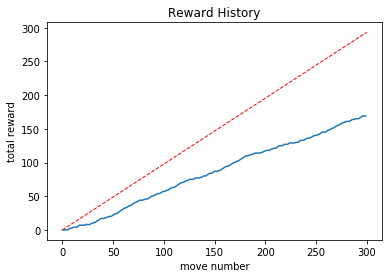

In [261]:
game = Game(300)
bandits = [Bandit(game) for i in range(10)]
solver = RandomSolver(bandits)
for i in range(game.num_moves):
    solver.move()
game.plot_history()

## A Better Solver

In [234]:
class EpsilonGreedySolver:
    def __init__(self, bandits, epsilon = .1):
        self.bandits = bandits
        self.epsilon = epsilon
        self.trials_per_bandit  = [0 for i in range(len(bandits))]
        self.rewards_per_bandit = [0 for i in range(len(bandits))]
        self.score_per_bandit = [0 for i in range(len(bandits))]
        
    def move(self):
        """Pulls one of this solver's bandits and returns True if a reward results,
        False, otherwise."""
        if np.random.uniform() < self.epsilon:
            # choose a bandit at random
            chosen = np.random.randint(0,len(self.bandits))
        else:
            # choose one of the bandits with highest payoff at random
            max_score = 0 #keep track of best score as we look through bandits
            best = [] # store the indices of the best scoring bandits
            
            for i in range(len(bandits)):
                if self.score_per_bandit[i] == max_score:
                    best.append(i)
                if self.score_per_bandit[i] > max_score:
                    best = [i]
                    max_score = self.score_per_bandit[i]
            chosen = np.random.choice(best)
                    
        result = self.bandits[chosen].pull()
        self.trials_per_bandit[chosen] += 1
        self.rewards_per_bandit[chosen] += result
        self.score_per_bandit[chosen] = self.rewards_per_bandit[chosen] / \
                                        self.trials_per_bandit[chosen]
        return result

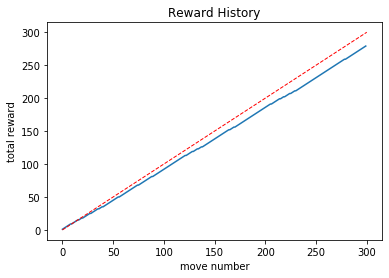

In [256]:
game = Game(300)
bandits = [Bandit(game) for i in range(10)]
solver = EpsilonGreedySolver(bandits)
for i in range(game.num_moves):
    solver.move()
game.plot_history()

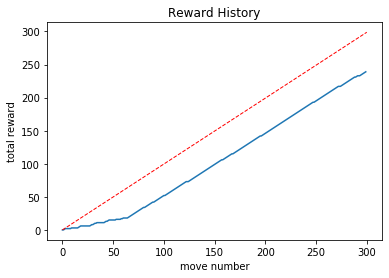

In [206]:
bandits

[Bandit with secret probability 0.9634249639419814,
 Bandit with secret probability 0.2114462335016255,
 Bandit with secret probability 0.08151223944518082,
 Bandit with secret probability 0.6907632023150133,
 Bandit with secret probability 0.6708777315924971,
 Bandit with secret probability 0.630220909143986,
 Bandit with secret probability 0.5329442561351789,
 Bandit with secret probability 0.2919147163985354,
 Bandit with secret probability 0.6422624591679195,
 Bandit with secret probability 0.12402847909709791]

In [207]:
solver.score_per_bandit

[0.9411764705882353,
 0.0,
 0.25,
 0.7383177570093458,
 0.5,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.0]